In [1]:
import numpy as np
import pandas as pd
import csv
from scipy.stats import bernoulli
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from functools import partial
plt.style.use('seaborn-poster')

%matplotlib inline

LAMBDA = 1.0#0.0000215
METHOD = 'RK45'
N_DAYS = 14
TIMESTEPS = 2e3

Retrieve saved graphs and initial values from `graph_init.ipynb`

In [15]:
G = np.loadtxt(open('../data/graph_complete.csv'), delimiter=",")
G.sum(1)

array([ 0.,  5.,  1., ...,  1., 11.,  1.])

In [16]:
nodes = pd.read_csv(open('../data/empirical_graph_nodes.csv'), delimiter=",").drop(['Unnamed: 0'], 1)
nodes

/tmp/ipykernel_22394/2665460425.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  nodes = pd.read_csv(open('../data/empirical_graph_nodes.csv'), delimiter=",").drop(['Unnamed: 0'], 1)


,step,date,domain,_id,children
0,0.0,2021-01-06,537508,1816056005,[]
1,NaN,2021-01-06,4452,1816132855,[]
2,NaN,2021-01-06,267703,1816195886,[]
3,NaN,2021-01-06,100063,1816238212,[]
4,NaN,2021-01-06,23539,1816336438,[]
...,...,...,...,...,...
2969,NaN,2021-02-05,38907,1843892109,[]
2970,NaN,2021-02-05,368186,1843827906,[]
2971,NaN,2021-02-05,157349,1843729662,[]
2972,NaN,2021-02-05,158115,1843976290,[]


Load the list of domains (posts' sources)

In [17]:
with open('../data/graph_original_domains_each_node.txt') as f:
    domains = f.read().splitlines()
len(domains)

2651

In [ ]:
# # create dictionary, one colour to each domain
# total_d = list(set(domains))
# cols = colors.keys()
# color_dict = {'a': 1}

# for pos, i in enumerate(total_d):
#     color_dict[i] = cols[pos]

Get the initial conditions

In [18]:
eig = np.linalg.eig(G)[0].max()
eig

(136.82923238946915+0j)

In [19]:
i0 = np.loadtxt(open('../data/i0.csv'), delimiter=",")
s0 = 1-i0
total_articles = len(i0)
i0

array([1., 1., 1., ..., 0., 0., 0.])

Define the ODE function to pass to a ODE solver

In [10]:
def fun(
    t, # timestep
    y, # old state
    pars, # ODE fixed parrameters
):
    # Get the old state, numpify it
    y = np.array(y)
    # Separate infected (i) and susceptibles (s)
    i, s = y[:total_articles], y[total_articles:]
    # Get ODE fixed parameters, i.e. lambda and a_ij
    A, lamb = pars
    # Get contacts vectors
    M =  (i * A).sum(axis=1)
    # Get trasmission scusceptibles
    N = lamb * s
    # Get new infected
    Q = N*M
    # Propagate for getting delta infected
    dI = -i + Q
    # Propagate for getting delta susceptible
    dS = -Q
    # Return new state
    return np.hstack((dI,dS))

In [22]:
f = partial(fun, pars=(G, LAMBDA))
sol = solve_ivp(
    fun=f,
    t_span=[0,N_DAYS],
    y0=list(i0)+list(s0),
    method=METHOD,
    t_eval=np.linspace(0,N_DAYS,TIMESTEPS))
sol

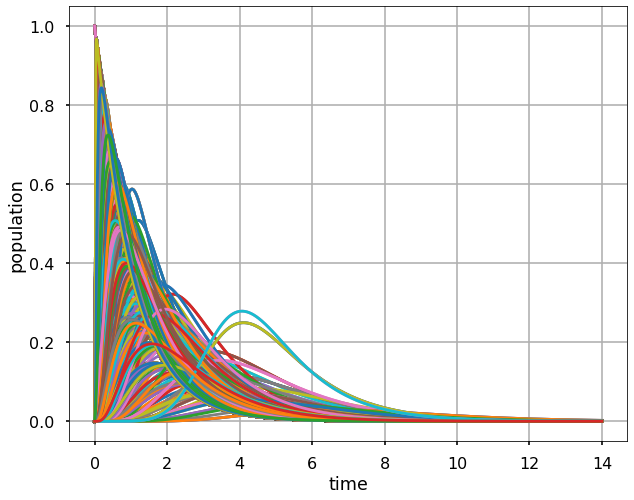

In [23]:
plt.figure(figsize = (10, 8))
[plt.plot(sol.t, sol.y[i, :]) for i in range(total_articles)]
plt.xlabel('time')
plt.ylabel('population')
#plt.legend(['solution {}'.format(i) for i in range(len(sol.y[:total_articles]))])
plt.grid(True)
plt.show()

In [24]:
def create_dI(sol):
    s = len(sol[0][1])/2
    dI = np.zeros((len(sol), s))
    dS = np.zeros((len(sol), s))
    c = 0
    for i,v in sol:
        dI[c:] = v[:s]
        dS[c:] = v[s:]
        c+=1
    return dI, dS

def create_infects(dI,dS):
    dR = 1-(dS+dI)

    Infects = np.zeros(dI.shape)
    Infects[0] = dI[0]

    S0 = np.ones(dI.shape[1]) - Infects[0]
    R0 = np.zeros(dI.shape[1])
    I0 = Infects[0]

    for t in range(1,dI.shape[0]):

        I = bernoulli.rvs(dI[t]*S0)
        R = bernoulli.rvs(dR[t]*I0)

        Infects[t] = I0 - R + I
        a = Infects[t]

        if len(a[a<0]) > 0:
            b = I0-R
            if len(b[b<0])>0:
                print('ei')


        I0 = Infects[t]
        S0 = S0 - I

    return(Infects)

In [25]:
dI, dS = create_dI(sol.y)
Infects = create_infects(dI,dS)

TypeError: object of type 'numpy.float64' has no len()

In [ ]:
# def plot_sol(sol, color_dict, domains):
#     plots = list_plot([(j[0],j[1][0]) for j in sol[:total_articles]], color=color_dict[domains[0]], plotjoined=True, alpha=.8, gridlines=true)
#     for i in range(500):
#         co = color_dict[domains[i]]
#         plots += list_plot([(j[0], j[1][i]) for j in sol[:total_articles]], color=co, plotjoined=True, alpha=.2, gridlines=true)
#     plots.save('../data//simulation.png')



## dI- matrix com a probabilidade do artigo ser infectado no tempo t. dI[0] - artigos infectados no tempo 0
## Infects - matrix boolean com os infectados no tempo t.
## recebe T.solution

def create_dI(sol):
    s = len(T.solution[0][1])/2
    dI = np.zeros((len(T.solution), s))
    dS = np.zeros((len(T.solution), s))
    c = 0
    for i,v in sol:
        dI[c:] = v[:s]
        dS[c:] = v[s:]
        c+=1
    return dI, dS

def create_infects(dI,dS):
    dR = 1-(dS+dI)

    Infects = np.zeros(dI.shape)
    Infects[0] = dI[0]

    S0 = np.ones(dI.shape[1]) - Infects[0]
    R0 = np.zeros(dI.shape[1])
    I0 = Infects[0]

    for t in range(1,dI.shape[0]):

        I = bernoulli.rvs(dI[t]*S0)
        R = bernoulli.rvs(dR[t]*I0)

        Infects[t] = I0 - R + I
        a = Infects[t]

        if len(a[a<0]) > 0:
            b = I0-R
            if len(b[b<0])>0:
                print('ei')


        I0 = Infects[t]
        S0 = S0 - I

    return(Infects)


def create_infected_matrix(la, T):
    T.ode_solve(t_span=[0, 14], y_0=list(i0)+list(s0), num_points=16, params=[G, la])
    plot_sol(T.solution, color_dict, domains)

    dI, dS = create_dI(T.solution)
    Infects = create_infects(dI,dS)

    return dI, Infects


In [ ]:


T = ode_solver()
T.algorithm = "rkf45"
T.function = fun
l = 0.0000215


dI, Infects = create_infected_matrix(l, T)
np.savetxt('../data//dI.csv', dI, delimiter=',')
np.savetxt('../data//Infects.csv', Infects, delimiter=',')